# Imports

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from IPython.display import Image
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARMA, ARIMA
from sklearn.metrics import explained_variance_score
from matplotlib.finance import fetch_historical_yahoo, parse_yahoo_historical_ochl

rcParams['figure.figsize'] = 15, 5

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


# Load Data in Memory

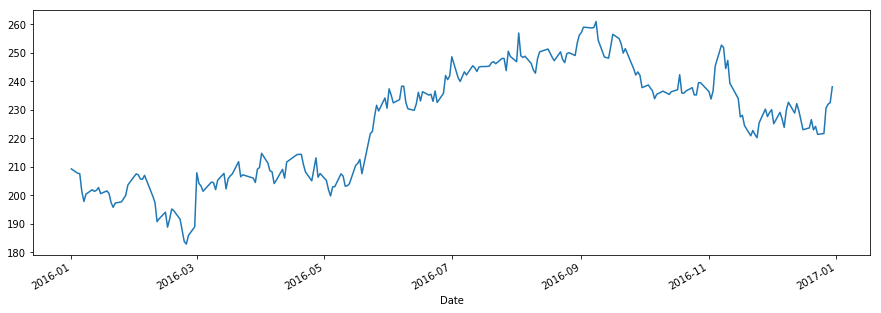

In [2]:
path = "C:\\Users\\rohit\\OneDrive\\Udacity ML\\machine-learning-master\\projects\\capstone\\Stock Time Series Analysis\\"
yahoo_data = pd.read_csv(path+'ITC.NS.csv',index_col=[0],parse_dates=True,dayfirst=False)
yahoo_data['Adj Close']['2016'].plot()

# Plot Time Series

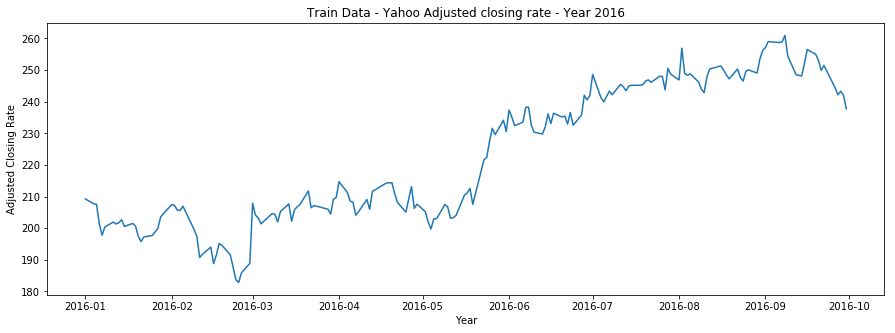

In [3]:
dates = yahoo_data.index.values
values = yahoo_data['Adj Close'].values
data = pd.DataFrame({'Close_Adj':values}, index=dates)
data = data["2016"]
date_thresh = datetime.strptime('2016-10-01',"%Y-%m-%d").date()

data_train = data[:date_thresh]
data_test = data[date_thresh:]


plt.plot(data_train.index, data_train['Close_Adj'])
plt.xlabel('Year')
plt.ylabel('Adjusted Closing Rate')
plt.title('Train Data - Yahoo Adjusted closing rate - Year 2016')

# Evaluating Stationarity

No Trend Exists.
Mean remains constant.
Variance remains constant.
No Autocorrelation.



In [4]:
def evaluate_stationarity(timeseries, t=30):
    
    '''
    Initialize window month t = 30
    Calculate Rolling Mean
    Calculate Rolling Std Dev
    Plot the Data
    Perform Dicky Fuller Test of Stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=t).mean()
    rolstd = timeseries.rolling(window=t).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

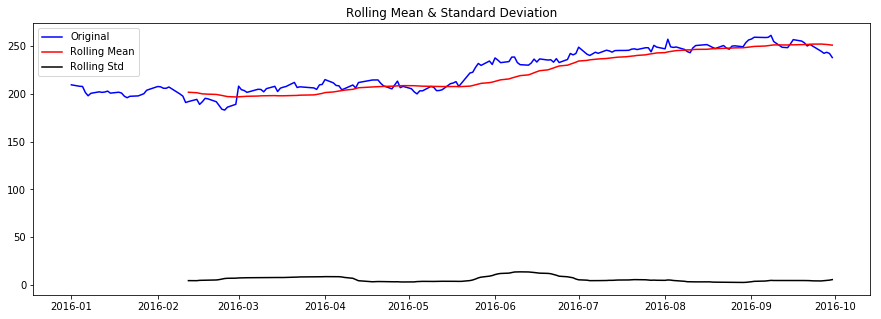

Results of Dickey-Fuller Test:
Test Statistic                  -1.102271
p-value                          0.714166
#Lags Used                       0.000000
Number of Observations Used    184.000000
Critical Value (5%)             -2.877380
Critical Value (1%)             -3.466398
Critical Value (10%)            -2.575214
dtype: float64


In [5]:
evaluate_stationarity(data_train['Close_Adj'], 30)

In [6]:
"Test Statistic greater than crticial values, hence null hypothesis not rejected"

'Test Statistic greater than crticial values, hence null hypothesis not rejected'

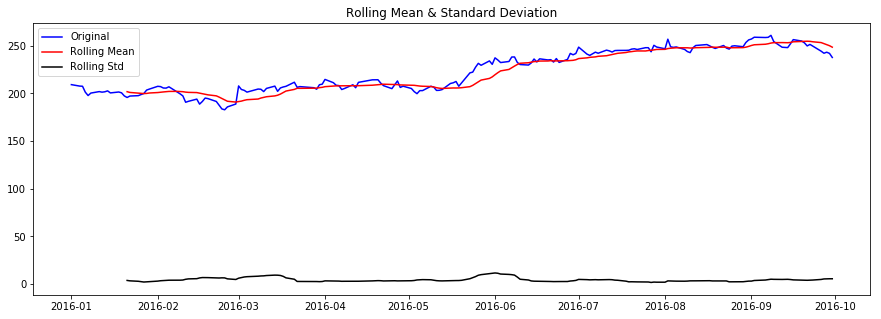

Results of Dickey-Fuller Test:
Test Statistic                  -1.102271
p-value                          0.714166
#Lags Used                       0.000000
Number of Observations Used    184.000000
Critical Value (5%)             -2.877380
Critical Value (1%)             -3.466398
Critical Value (10%)            -2.575214
dtype: float64


In [7]:
evaluate_stationarity(data_train['Close_Adj'], 15)

In [8]:
"Test Statistic greater than crticial values, hence null hypothesis not rejected"

'Test Statistic greater than crticial values, hence null hypothesis not rejected'

# Making a time series object stationary

Apply transformations. Estimate trend and remove from original series. Differencing. Decomposition.

# Log transformation

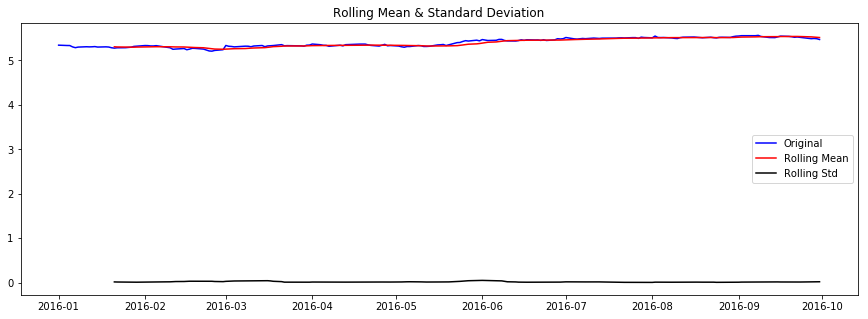

Results of Dickey-Fuller Test:
Test Statistic                  -1.112577
p-value                          0.710030
#Lags Used                       0.000000
Number of Observations Used    184.000000
Critical Value (5%)             -2.877380
Critical Value (1%)             -3.466398
Critical Value (10%)            -2.575214
dtype: float64


In [9]:
data_log = np.log(data_train['Close_Adj'])
evaluate_stationarity(data_log, 15)

In [10]:
"Test Statistic greater than crticial values, hence null hypothesis not rejected . Zoom in the plot"

'Test Statistic greater than crticial values, hence null hypothesis not rejected . Zoom in the plot'

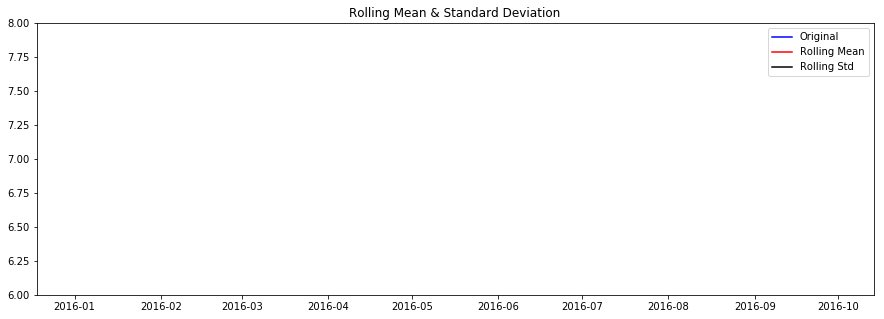

In [11]:
data_log = np.log(data_train['Close_Adj'])

#Determing rolling statistics
rolmean = data_log.rolling(window=15).mean()
rolstd = data_log.rolling(window=15).std()

#Plot rolling statistics:
orig = plt.plot(data_log, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.ylim([6,8])
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [12]:
"mean does vary"

'mean does vary'

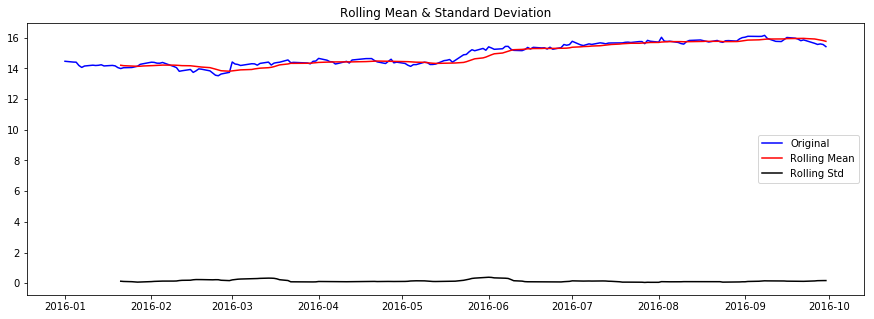

Results of Dickey-Fuller Test:
Test Statistic                  -1.105433
p-value                          0.712900
#Lags Used                       0.000000
Number of Observations Used    184.000000
Critical Value (5%)             -2.877380
Critical Value (1%)             -3.466398
Critical Value (10%)            -2.575214
dtype: float64


In [13]:
data_sqrt = np.sqrt(data_train['Close_Adj'])
evaluate_stationarity(data_sqrt, 15)

In [14]:
"Still not stationary"

'Still not stationary'

# Moving Average Smoothing

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=15,center=False).mean()
  """Entry point for launching an IPython kernel.


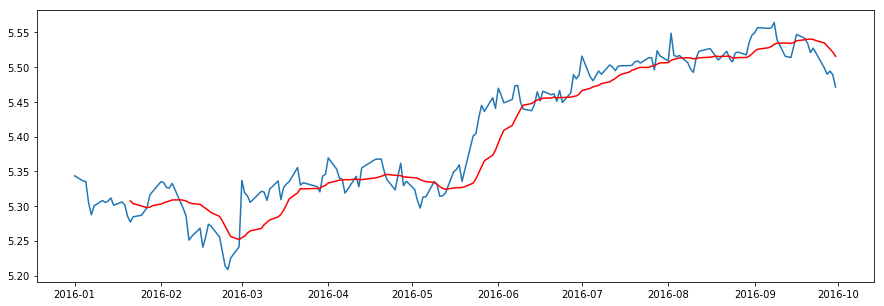

In [15]:
moving_avg = pd.rolling_mean(data_log,15)
plt.plot(data_log)
plt.plot(moving_avg, color='red')

# Substract the rolling mean from the log transformed series

In [16]:
data_log_moving_avg_diff = data_log - moving_avg
data_log_moving_avg_diff.head(15)

2016-01-01         NaN
2016-01-04         NaN
2016-01-05         NaN
2016-01-06         NaN
2016-01-07         NaN
2016-01-08         NaN
2016-01-11         NaN
2016-01-12         NaN
2016-01-13         NaN
2016-01-14         NaN
2016-01-15         NaN
2016-01-18         NaN
2016-01-19         NaN
2016-01-20         NaN
2016-01-21   -0.030412
Name: Close_Adj, dtype: float64

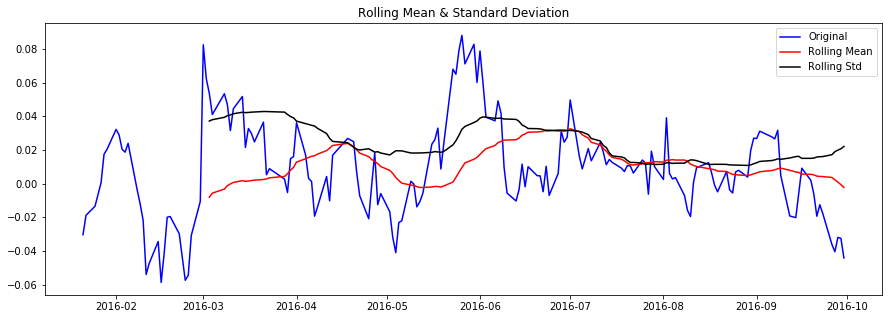

Results of Dickey-Fuller Test:
Test Statistic                  -3.733085
p-value                          0.003671
#Lags Used                       0.000000
Number of Observations Used    170.000000
Critical Value (5%)             -2.878696
Critical Value (1%)             -3.469413
Critical Value (10%)            -2.575917
dtype: float64


In [17]:
data_log_moving_avg_diff.dropna(inplace=True)
evaluate_stationarity(data_log_moving_avg_diff)

In [18]:
"Better. Series stationary at 5%"

'Better. Series stationary at 5%'

# EWMA

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pd.ewm_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.ewm(adjust=True,halflife=15,ignore_na=False,min_periods=0).mean()
  """Entry point for launching an IPython kernel.


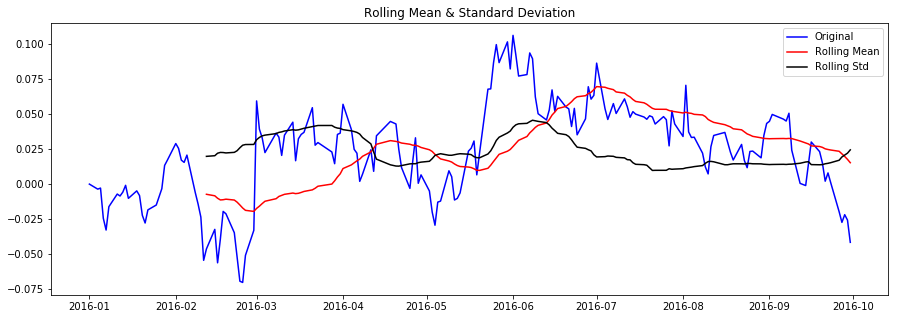

Results of Dickey-Fuller Test:
Test Statistic                  -2.885622
p-value                          0.047046
#Lags Used                       0.000000
Number of Observations Used    184.000000
Critical Value (5%)             -2.877380
Critical Value (1%)             -3.466398
Critical Value (10%)            -2.575214
dtype: float64


In [19]:
expwighted_avg = pd.ewma(data_log, halflife=15)
data_log_ewma_diff = data_log - expwighted_avg
evaluate_stationarity(data_log_ewma_diff)

In [20]:
"Better. Series stationary at 5%"

'Better. Series stationary at 5%'

# Differencing

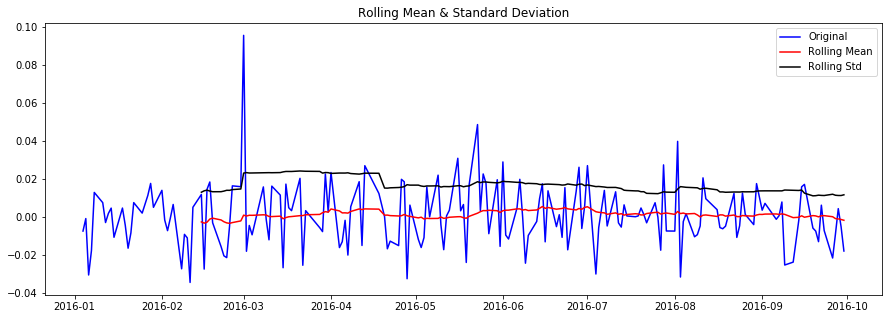

Results of Dickey-Fuller Test:
Test Statistic                -8.260867e+00
p-value                        5.087785e-13
#Lags Used                     3.000000e+00
Number of Observations Used    1.800000e+02
Critical Value (5%)           -2.877735e+00
Critical Value (1%)           -3.467211e+00
Critical Value (10%)          -2.575403e+00
dtype: float64


In [21]:
data_log_diff = data_log - data_log.shift()
data_log_diff.dropna(inplace=True)
evaluate_stationarity(data_log_diff)

In [22]:
"Remarkable improvement."

'Remarkable improvement.'

In [23]:
"So MA and EWMA removed trend. Differencing removes both trend and seasonality."

'So MA and EWMA removed trend. Differencing removes both trend and seasonality.'

# Decomposition

In [24]:
"Decomposition breaks time series into three components: trend, seasonality and residuals. The component of interest is residuals."

'Decomposition breaks time series into three components: trend, seasonality and residuals. The component of interest is residuals.'

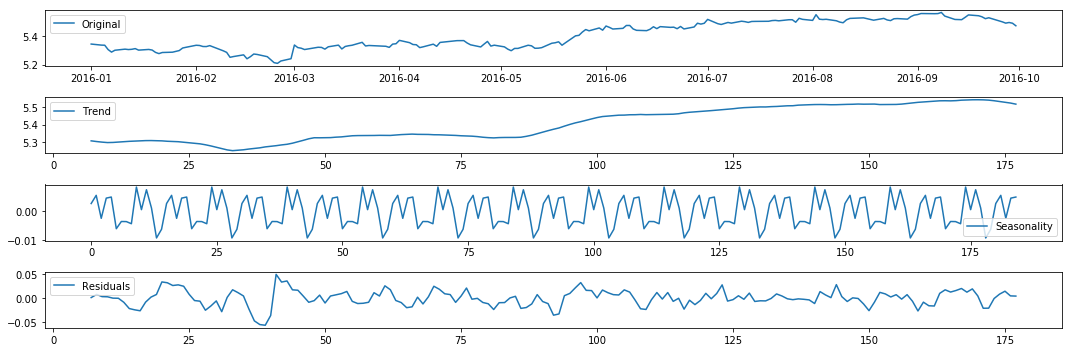

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(list(data_log), freq=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(data_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Evaluating stationarity of residuals

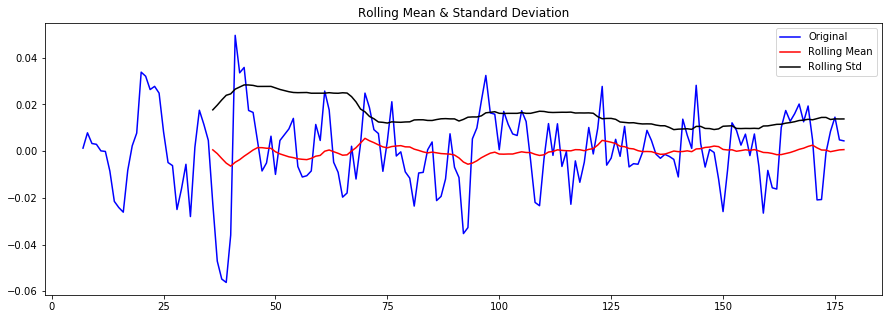

Results of Dickey-Fuller Test:
Test Statistic                -8.100583e+00
p-value                        1.303131e-12
#Lags Used                     3.000000e+00
Number of Observations Used    1.670000e+02
Critical Value (5%)           -2.879008e+00
Critical Value (1%)           -3.470126e+00
Critical Value (10%)          -2.576083e+00
dtype: float64


In [26]:
data_log_decompose = pd.Series(residual)
data_log_decompose.dropna(inplace=True)
evaluate_stationarity(data_log_decompose)

In [27]:
"So data can be made stationary either by differencing or looking at residuals after decomposition."

'So data can be made stationary either by differencing or looking at residuals after decomposition.'

In [28]:
"For stationarity data has to have constant mean, variance, no trend and autocorrelation exists. Next we check for autocorrelation."

'For stationarity data has to have constant mean, variance, no trend and autocorrelation exists. Next we check for autocorrelation.'

# Autocorrelation

In [29]:
"Correlation between the elements of a series and others from the same series separated from them by a given interval."

'Correlation between the elements of a series and others from the same series separated from them by a given interval.'

# Partial Autocorrelation

In [30]:
"The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags."


'The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.'

In [31]:
"https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/"

'https://machinelearningmastery.com/gentle-introduction-autocorrelation-partial-autocorrelation/'

# Durbin Watson Statistic

In [32]:
sm.stats.durbin_watson(data_log_diff)

2.0974965984059284

In [33]:
"Statistical test to check autocorrelation. Number between 0 and 4 where 0 is strong positive autocorrelation 4 is strong negative and 2 no autocorrelation."

'Statistical test to check autocorrelation. Number between 0 and 4 where 0 is strong positive autocorrelation 4 is strong negative and 2 no autocorrelation.'

# Plotting Correlograms for ACF and PACF on Log Transformed Differencing

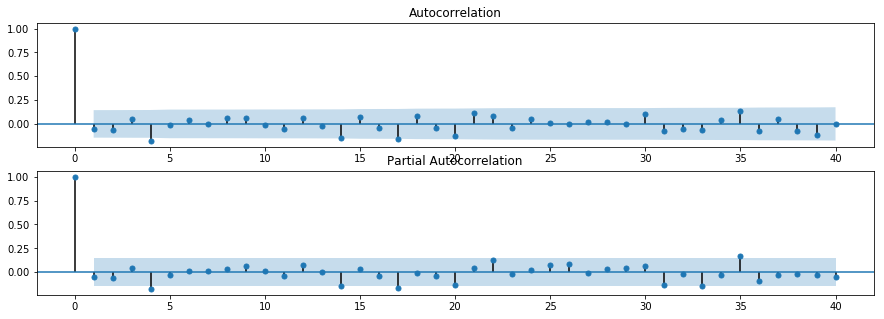

In [34]:
ax1 = plt.subplot(211)
fig = sm.graphics.tsa.plot_acf(data_log_diff.squeeze(), lags=40, ax=ax1)
ax2 = plt.subplot(212)
fig = sm.graphics.tsa.plot_pacf(data_log_diff, lags=40, ax=ax2)

In [35]:
"No Autocorrel or Partial Aurocorrel exists."

'No Autocorrel or Partial Aurocorrel exists.'

# Modelling a time series

In [36]:
"AR or p : Number of auto regressive terms. MA or q : Number of moving average terms. d: order of differencing."

'AR or p : Number of auto regressive terms. MA or q : Number of moving average terms. d: order of differencing.'

# ARIMA

In [37]:
"Auto Regressive Integrated Moving Average"

'Auto Regressive Integrated Moving Average'

In [38]:
"Model which is a linear equation dependent on p, d and q."

'Model which is a linear equation dependent on p, d and q.'

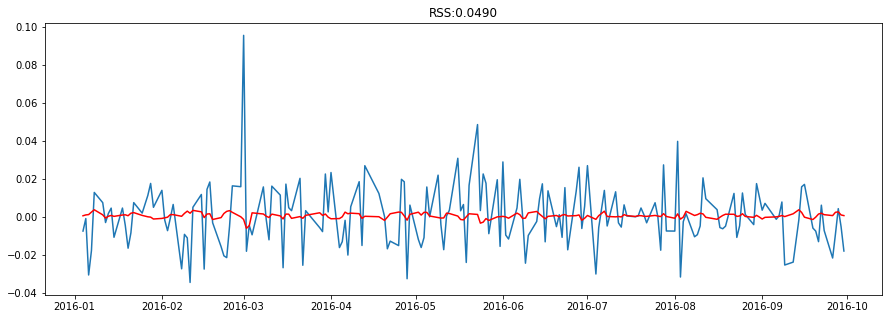

In [39]:
"ARMA Model, q = 0"
model = ARIMA(data_log,order=(2,1,0))
dates = data_log.index.to_datetime()
results_AR_210 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_210.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_AR_210.fittedvalues-data_log_diff)**2))

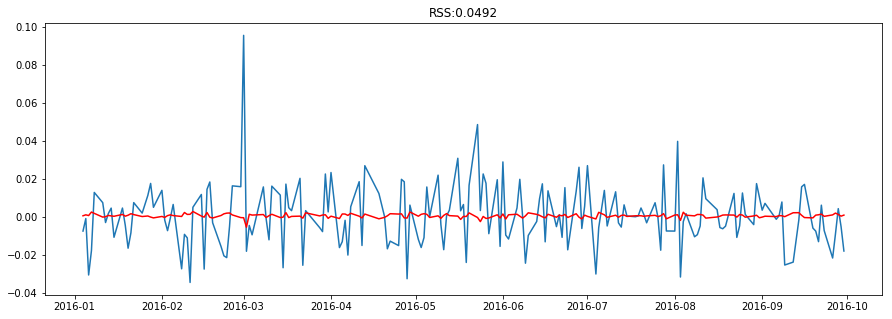

In [40]:
"MA Model, p = 0"
model = ARIMA(data_log,order=(0,1,1))
dates = data_log.index.to_datetime()
results_AR_011 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_011.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_AR_011.fittedvalues-data_log_diff)**2))

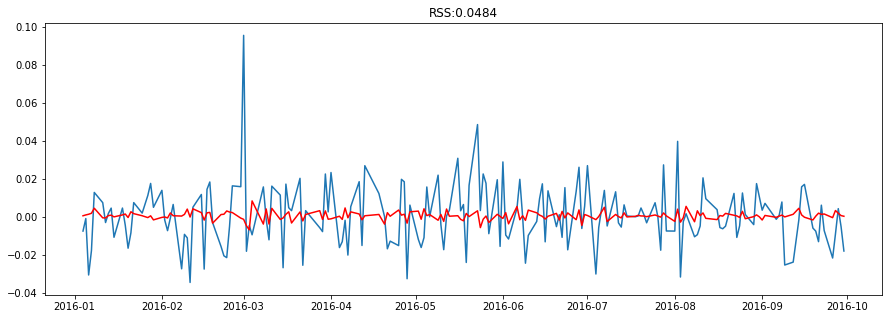

In [41]:
"ARIMA Model"
model = ARIMA(data_log,order=(2,1,1))
dates = data_log.index.to_datetime()
results_AR_211 = model.fit(disp=-1)
plt.plot(data_log_diff)
plt.plot(results_AR_211.fittedvalues,color='red')
plt.title('RSS:%.4f'%sum((results_AR_211.fittedvalues-data_log_diff)**2))

# Scaling back

In [42]:
predictions_ARIMA_diff = pd.Series(results_AR_211.fittedvalues,copy=True)
predictions_ARIMA_diff.head()

2016-01-04    0.000708
2016-01-05    0.001151
2016-01-06    0.001510
2016-01-07    0.002028
2016-01-08    0.004677
dtype: float64

In [43]:
print (data_train.head())

             Close_Adj
2016-01-01  209.247437
2016-01-04  207.714035
2016-01-05  207.554947
2016-01-06  201.325424
2016-01-07  197.811020


In [44]:
'Parameter d caused data to start after one day'

'Parameter d caused data to start after one day'

In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_diff_cumsum.head()

2016-01-04    0.000708
2016-01-05    0.001859
2016-01-06    0.003369
2016-01-07    0.005397
2016-01-08    0.010074
dtype: float64

In [46]:
print (results_AR_211.aic)
'Lower the score, better the quality of the time series model.'

-984.4391578903304


'Lower the score, better the quality of the time series model.'

In [47]:
'''
SCALE BACK
- remove differencing
- reverse log transformation
- evaluate the forecasted series
'''

predictions_ARIMA_log = pd.Series(data_log.ix[0], index = data_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

C:\Anaconda_Feb16\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


2016-01-01    5.343517
2016-01-04    5.344226
2016-01-05    5.345377
2016-01-06    5.346887
2016-01-07    5.348915
dtype: float64

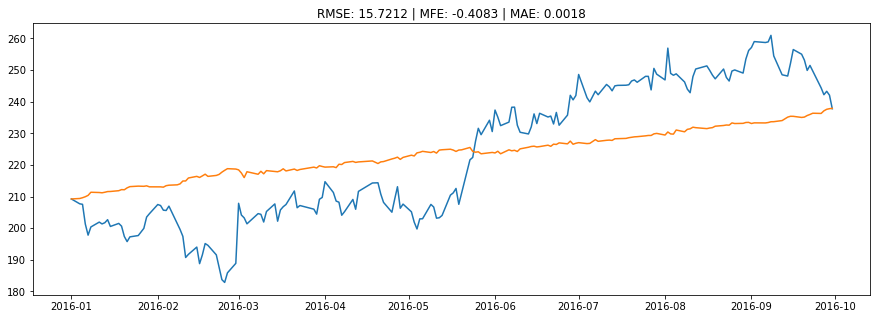

In [48]:
def mean_forecast_err(y, yhat):
    return y.sub(yhat).mean()

def mean_absolute_err(y, yhat):
    return np.mean((np.abs(y.sub(yhat).mean()) / yhat)) # or percent error = * 100


def rmse(y, yhat):
    return np.sqrt(sum((yhat-y)**2)/len(y))


predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(data_train['Close_Adj'])
plt.plot(predictions_ARIMA)

plt.title('RMSE: %.4f | MFE: %.4f | MAE: %.4f'% (
        rmse(data_train['Close_Adj'], predictions_ARIMA), mean_forecast_err(
            data_train['Close_Adj'], predictions_ARIMA), mean_absolute_err(
            data_train['Close_Adj'], predictions_ARIMA)))

In [49]:
"Forecasted time series resembled Linear Regression"

'Forecasted time series resembled Linear Regression'

In [50]:
from sklearn.metrics import mean_squared_error
print (np.sqrt(mean_squared_error(data_train['Close_Adj'], predictions_ARIMA)))

15.7212349551


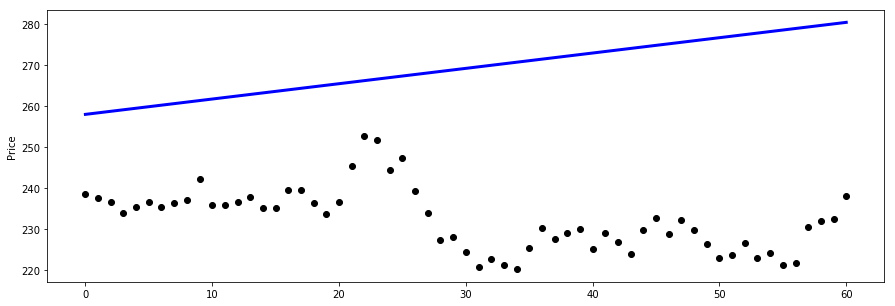

In [51]:
regr = LinearRegression()

x_train = [[x] for x in range(len(data_train))]
y_train = [[y] for y in list(data_train['Close_Adj'])]

#train last data point
x = x_train[-1][0]
x_test = [[z] for z in range(x+1,x+1+len(data_test))]

regr.fit(x_train, y_train)

y_pred = regr.predict(x_test)

explained_variance_score(data_test['Close_Adj'], y_pred)

plt.scatter(range(len(data_test)), data_test['Close_Adj'],  color='black')
plt.plot(range(len(data_test)), y_pred, color='blue',
             linewidth=3)
plt.ylabel('Price')


In [52]:
'https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/'

'https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/'

In [53]:
'https://machinelearningmastery.com/make-sample-forecasts-arima-python/'

'https://machinelearningmastery.com/make-sample-forecasts-arima-python/'

61
61


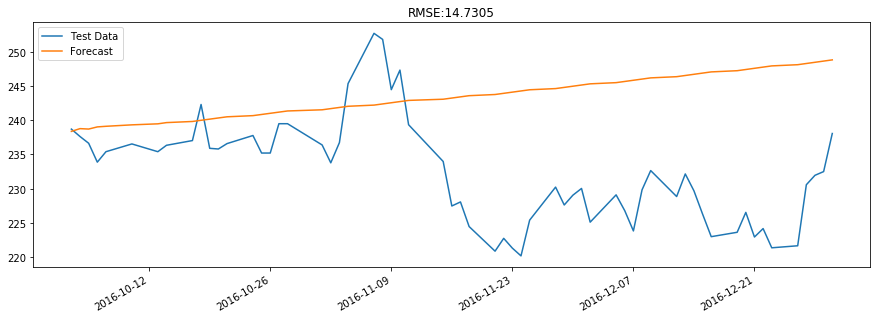

In [54]:
forecast_values = np.exp(results_AR_211.forecast(steps=len(data_test))[0])

print (len(forecast_values))
print (len(data_test['Close_Adj']))

compared_out_of_sample = pd.concat([pd.Series(data_test['Close_Adj'].values),pd.Series(forecast_values)],join='outer',axis=1)

compared_out_of_sample.index = data_test['Close_Adj'].index
compared_out_of_sample.columns = ['Test Data','Forecast']

compared_out_of_sample.plot()
plt.title('RMSE:%.4f'%np.sqrt(mean_squared_error(data_test['Close_Adj'], forecast_values)))

# Summary

In [55]:
'Introduced concept of ARIMA. Remove stationarity and predict out of sample results. Taking log difference creates stationarity.So instead of absolute values we should move to change.'

'Introduced concept of ARIMA. Remove stationarity and predict out of sample results. Taking log difference creates stationarity.So instead of absolute values we should move to change.'